### NN Model For Line Properties

Author: Jerry Chen

General Overview:

Input Parameters In Order
* Flowrate - Q (uL/min)
* Gantry Travel speed - V<sub>g</sub> (mm/min)
* LDR - Q/V<sub>g</sub>
* Print Height (mm)

Output Parameters In Order
* Average Width (μm)
* Average Thickness (μm)

Notes
* Use categorized linear regression Plot Q,V, Line Width show LDR coefficent determination 0.9


In [242]:
# Importing libraries
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transform

import numpy as np

%matplotlib widget
import matplotlib.pylab as plt

torch.manual_seed(42)

use_cuda = True
device = 'cuda' if torch.cuda.is_available() and use_cuda else 'cpu'

# Class to represent dataset


class lineDataSet():

    def __init__(self):

        # Loading the csv file from the folder path
        # First row is data labels so delete
        data1 = np.loadtxt('cleanlinedata.csv', delimiter=',',
                           dtype=np.float32, skiprows=1)

        # First 4 column are class parameters
        # Last 2 are line properties
        # Data in Each Column
        # Q (uL/min), Vg (mm/min), LDR (μL/mm), Print Height (mm), Average Width (μm), Average Thickness (μm)

        # Zero center and normalize input and output data
        self.x = data1[:, [0, 1]]
        self.input_mean = np.mean(self.x, axis=0)
        self.input_std = np.std(self.x, axis=0)
        self.x = torch.from_numpy((self.x-self.input_mean)/self.input_std)

        self.y = data1[:, 4:]
        self.output_mean = np.mean(self.y, axis=0)
        self.output_std = np.std(self.y, axis=0)
        self.y = torch.from_numpy((self.y-self.output_mean)/self.output_std)

        self.n_samples = data1.shape[0]

    # support indexing such that dataset[i] can
    # be used to get i-th sample
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples


dataset = lineDataSet()

first_data = dataset[0]
inputs, outputs = first_data
print(inputs, outputs)
print(inputs*dataset.input_std+dataset.input_mean,
      outputs*dataset.output_std+dataset.output_mean)

# Expected Output
# tensor([8.0976e+01, 1.9202e+03, 4.2170e-02, 2.0000e-01]) tensor([364.2700,  78.4050]


tensor([-1.5394,  1.5381]) tensor([-1.8517, -1.8783])
tensor([  80.9764, 1920.2285]) tensor([364.2700,  78.4050])


In [243]:
# Network model
class Network(nn.Module):
    def __init__(self, channels=1):  # default grayscale
        super().__init__()
        # self.batch1 = nn.BatchNorm1d(2)
        # BEST 2-6 6-2 2-2
        self.linear1 = nn.Linear(in_features=2, out_features=6)
        self.linear2 = nn.Linear(in_features=6, out_features=2)
        #self.linear3 = nn.Linear(in_features=4, out_features=4)
        #self.linear4 = nn.Linear(in_features=2, out_features=2)
        # self.linear5 = nn.Linear(in_features=2, out_features=2)
        # self.linear6 = nn.Linear(in_features=2, out_features=2)
        # self.linear7 = nn.Linear(in_features=2, out_features=2)
        self.out = nn.Linear(in_features=2, out_features=2)

    def forward(self, t):
        # t=self.batch1(t)
        t = self.linear1(t)
        t = torch.relu(t)
        t = self.linear2(t)
        t = torch.relu(t)
        #t = self.linear3(t)
        #t = torch.relu(t)
        #t = self.linear4(t)
        #t = torch.relu(t)
        # t = torch.tanh(t)
        # More layers generate more pronounced seperation
        # t = self.linear2(t)
        # t = F.tanh(t)
        t = self.out(t)
        return t


Using CUDA
step_size= 0.01 batch_size= 5 shuffle= True 

10
10
10
10
2
epoch:0	 avg_val_MSE_error:4.640465259552002
Prediction: -0.45 -0.58 Actual: -0.49 -0.49
10
10
10
10
2
epoch:1	 avg_val_MSE_error:12.627842903137207
Prediction: -0.04 -0.41 Actual: 0.29 0.29
10
10
10
10
2
epoch:2	 avg_val_MSE_error:5.133823871612549
Prediction: -0.44 -0.33 Actual: -1.00 -1.18
10
10
10
10
2
epoch:3	 avg_val_MSE_error:4.093273639678955
Prediction: -0.46 -0.27 Actual: -1.17 -0.36
10
10
10
10
2
epoch:4	 avg_val_MSE_error:7.735123634338379
Prediction: 0.55 0.25 Actual: 0.47 -0.18
10
10
10
10
2
epoch:5	 avg_val_MSE_error:5.640339374542236
Prediction: 0.55 0.38 Actual: 1.31 1.13
10
10
10
10
2
epoch:6	 avg_val_MSE_error:14.32677936553955
Prediction: 0.94 0.78 Actual: 0.61 -0.68
10
10
10
10
2
epoch:7	 avg_val_MSE_error:3.973505735397339
Prediction: -0.98 -0.81 Actual: -1.24 -0.91
10
10
10
10
2
epoch:8	 avg_val_MSE_error:6.5598249435424805
Prediction: -1.00 -0.88 Actual: -1.24 -0.91
10
10
10
10
2
epoch:9	 avg

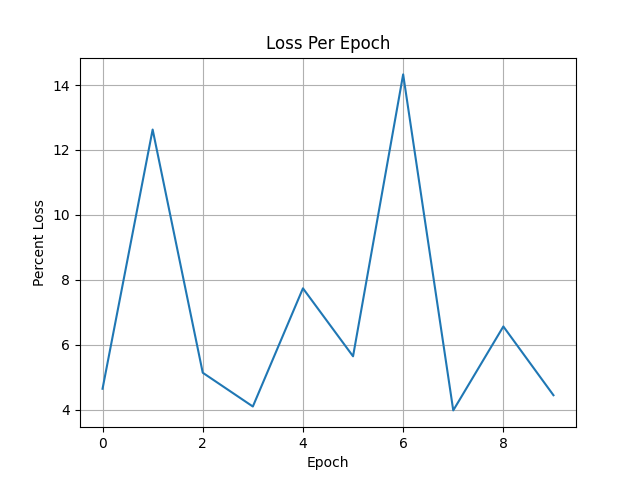

In [244]:
# Training
def train(step_size, batch_size=5, shuffle=False, num_epochs=5, plot_loss=False):
    # Loading in data
    dataset = lineDataSet()
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size

    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, test_size])
    dsets = {'train': train_dataset, 'val': val_dataset}

    # Data loading - batch_size and shuffle
    dest_loader = {x: torch.utils.data.DataLoader(
        dsets[x], batch_size=batch_size, shuffle=shuffle) for x in ['train', 'val']}

    # Start network
    network = Network()
    if device == "cuda":
        print("Using CUDA")
        network.cuda()

    # Training
    print('step_size=', step_size, 'batch_size=',
          batch_size, 'shuffle=', shuffle, '\n')

    optimizer = optim.Adam(network.parameters(), lr=step_size)

    best_epoch = 0
    best_epoch_loss = np.inf

    epoch_losses = []
    for epoch in range(num_epochs):
        avg_epoch_loss = 0
        for mode in ['train', 'val']:
            if mode == 'train':
                network.train(True)    # Set model to training mode
            else:
                network.train(False)    # Set model to Evaluation mode
                network.eval()

            for input_val, out_val in dest_loader[mode]:
                if device == "cuda":
                    input_val = input_val.cuda()
                    out_val = out_val.cuda()

                optimizer.zero_grad()    # Zero the gradients of the network weights prior to backprop
                # Forward pass through the network - Shape batch x output
                preds = network(input_val)

                # Compute the minibatch loss with mean squared error
                minibatch_loss = F.mse_loss(preds, out_val)

                if mode == 'val':
                    #error = torch.sqrt(torch.sum((preds-out_val)**2, dim=-1))
                    #real_val = torch.sqrt(torch.sum(out_val**2, dim=-1))

                    real_val = out_val

                    # Add minibatch loss to the epoch loss
                    avg_epoch_loss += torch.sum(100*torch.abs((preds-out_val)/real_val))
                    avg_epoch_loss /= torch.numel(real_val)
                    #print((error/real_val).shape)
                    # raise Exception("Finished code")

                if mode == 'train':  # only backprop through training loss and not validation loss
                    minibatch_loss.backward()
                    optimizer.step()

            if mode == 'val':
                avg_epoch_loss /= len(val_dataset)
                epoch_losses.append(avg_epoch_loss.cpu().detach().numpy())

                print(f"epoch:{epoch}\t avg_val_MSE_error:{avg_epoch_loss}")
                print("Prediction: {:.2f} {:.2f} Actual: {:.2f} {:.2f}".format(
                    preds[0][0].item(), preds[0][1].item(),
                    out_val[0][0].item(), out_val[0][1].item()))

                if avg_epoch_loss < best_epoch_loss:
                    best_epoch_loss = avg_epoch_loss
                    best_epoch = epoch
                    torch.save(network.state_dict(), f'best_model.pth')

    print(f"Best epoch {best_epoch}")

    if plot_loss:
        fig, ax = plt.subplots()
        ax.plot([i for i in range(num_epochs)], epoch_losses)
        ax.set(xlabel='Epoch', ylabel='Percent Loss',
               title='Loss Per Epoch')
        ax.grid()
        plt.show()

    return network


lr_list = [0.1, 0.01, 0.001]
batch_size_list = [10, 100, 1000]
shuffle_list = [True, False]

# hyperparameter grid search
# for param in product(lr_list, batch_size_list, shuffle_list):


best_network = train(0.01, shuffle=True, num_epochs=10, plot_loss=True)


Network(
  (linear1): Linear(in_features=2, out_features=6, bias=True)
  (linear2): Linear(in_features=6, out_features=2, bias=True)
  (out): Linear(in_features=2, out_features=2, bias=True)
)
tensor([[-0.8440,  0.4462],
        [-0.0064, -0.5519],
        [ 0.4897, -0.8188],
        [-0.8549, -0.2666],
        [ 0.0478, -1.0043],
        [ 1.0183, -0.4206]])
tensor([ 0.4898, -0.6284, -0.2133, -0.2820,  0.5294, -0.2571])
tensor([[ 0.6014, -0.3769, -0.1462,  0.1273, -0.1126, -0.4834],
        [-0.7313,  0.0628,  0.5844, -0.4582,  0.6762,  0.3777]])
tensor([0.2317, 0.5167])
tensor([[-0.5147,  0.8225],
        [-0.5134,  0.6424]])
tensor([-0.4255, -0.2584])


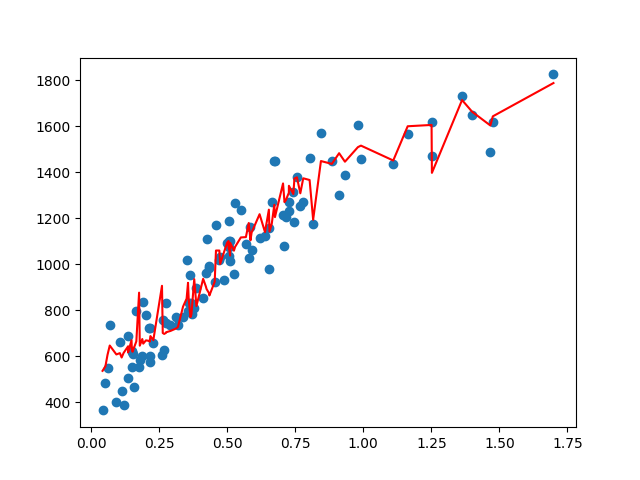

In [245]:
dataset = lineDataSet()

best_network = Network()
best_network.load_state_dict(torch.load('best_model.pth'))


print(best_network)

for m in best_network.modules():
    if isinstance(m, nn.Linear):
        print(m.state_dict()['weight'])
        print(m.state_dict()['bias'])


# Turn of gradiant
with torch.no_grad():
    best_network.eval()

    network = best_network.cpu()

    pred = network(dataset[:][0])

    # X = [Q (uL/min), Vg (mm/min)]
    # Y =  [Average Width (μm), Average Thickness (μm)]
    Q = dataset[:][0][:, 0]*dataset.input_std[0]+dataset.input_mean[0]
    Q = Q.numpy()
    flow_rate_sort_idx = np.argsort(Q)
    Q = Q[flow_rate_sort_idx]

    Vg = dataset[:][0][:, 1]*dataset.input_std[1]+dataset.input_mean[1]
    Vg = Vg.numpy()
    Vg = Vg[flow_rate_sort_idx]

    avg_width = dataset[:][1][:, 0] * \
        dataset.output_std[0]+dataset.output_mean[0]
    avg_width = avg_width.numpy()
    avg_width = avg_width[flow_rate_sort_idx]

    avg_width_pred = pred[:, 0] * \
        dataset.output_std[0] + dataset.output_mean[0]
    avg_width_pred = avg_width_pred.numpy()
    avg_width_pred = avg_width_pred[flow_rate_sort_idx]


    QVg=Q/Vg
    QVg_index= np.argsort(QVg)
    QVg=QVg[QVg_index]

    fig = plt.figure()
    ax=plt.axes()
    ax.plot(QVg, avg_width_pred[QVg_index],'r')
    ax.scatter(QVg, avg_width[QVg_index])
    #ax = plt.axes(projection="3d")

    #ax.scatter(Q, Vg, avg_width,  edgecolor='royalblue')
    #ax.scatter(Q, Vg, avg_width_pred,  edgecolor='royalblue')
    #ax.plot_trisurf(Q, Vg, avg_width,  edgecolor='royalblue')
    #ax.plot_trisurf(Q, Vg, avg_width_pred,  edgecolor='r')
    plt.show()

    '''
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))

    axs[0].plot(Q, avg_width, 'r')
    #axs[0].plot(Q, avg_width_pred, 'b')
    #axs[0].set_xlabel("Flow Rate")
    #axs[0].set_ylabel("Gantry Speed")
    #axs[0].set_zlabel("Print Width")
    axs[0].grid(True)

    # axs[1].plot(dataset[:][0][:, 0]+dataset.input_mean[2],
    #            dataset[:][1][:, 1], 'r')
    # axs[1].plot(dataset[:]# Q (uL/min), Vg (mm/min),LDR (μL/mm), Print Height (mm), Average Width (μm), Average Thickness (μm)[0][:, 0]+dataset.input_mean[2], pred[:, 1], 'b')
    # axs[1].set_xlabel("LDR")
    # axs[1].set_ylabel("Average Height")
    # axs[1].grid(True)

    plt.tight_layout()
    plt.show()
  
    # for param in network.parameters():
    #    print(param)
    '''